In [2]:
import keras 
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import tensorflow as tf

import numpy as np

import random
import os
import pandas as pd

from tensorflow import keras
from keras.utils import to_categorical

import numpy as np

from sklearn.metrics.pairwise import rbf_kernel

import matplotlib.pyplot as plt

c:\Users\Alex\Programming\udl_takehome\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Create a CNN as specified in the paper, FCHOLLET

In [3]:
input_shape = (28, 28, 1)
num_classes = 10

def create_model():
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

create_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       495,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,994 (1.96 MB)

 Trainable params: 513,994 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

Load the MNIST dataset
https://keras.io/api/datasets/mnist/

In [4]:
keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Prepare the data
https://keras.io/examples/vision/mnist_convnet/

In [5]:
keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

The main active learning loop

In [6]:
def run_active_learning(find_max_acquisition, name="", T=100, non_deterministic=True,
                        num_rounds=100, k=10, lam=0):
    """
    Check whether we have any results saved to avoid very expensive re-calculations
    """
    if os.path.exists(name+".csv"):
        print("Save found for " + name)
        df = pd.read_csv(name+".csv")
        return df["label_history"].tolist(), df["accuracy_history"].tolist()

    print("Save not found for " + name)
    """ 
    Split the training dataset into:
    100 validation indices
    20 initially labelled indices
    60,000 - 100 - 20 unlabelled indices (pool)

    Shuffle for randomness
    """
    all_indices = list(range(len(x_train)))
    random.shuffle(all_indices)

    validation_indices = all_indices[:100]
    labelled_indices = all_indices[100:120]
    pool_indices = all_indices[120:]

    """ 
    Keep track of the accuracies as we increase the labelled dataset
    """
    label_history = []
    accuracy_history = []

    for round_num in range(num_rounds):
        """ 
        Create new CNN, and fit it to the labelled data
        Early stopping citation: https://keras.io/api/callbacks/early_stopping/, 
        to stop training when the accuracy is not improving
        """
        early_stop = keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=3,
            restore_best_weights=True
        )
        model = create_model()
        model.fit(
            x_train[labelled_indices],
            y_train[labelled_indices],
            epochs=20, 
            batch_size=32,
            validation_data=(
                x_train[validation_indices],
                y_train[validation_indices]
            ),
            verbose=0, 
            callbacks=[early_stop]
        )

        """ 
        Evaluate the accuracy
        """
        accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
        accuracy_history.append(accuracy)
        label_history.append(len(labelled_indices))
        print("Round " + str(round_num) + " accuracy: " + str(accuracy))

        """
        Occasionally save data in case computation crashes
        I am not implementing any resume logic unless I need it
        """
        if round_num % 10:
            dataframe = pd.DataFrame( {
                "label_history": label_history, 
                "accuracy_history": accuracy_history
            })
            dataframe.to_csv(name+"_checkpoint.csv", index=False)

        """ 
        Find the next indices to label
        """
        acquired_indices = find_max_acquisition(model, pool_indices, x_train, k=k, T=T, non_deterministic=non_deterministic, lam=lam)
        for acquired_index in acquired_indices:
            labelled_indices.append(acquired_index)
            pool_indices.remove(acquired_index)

        del model
        keras.backend.clear_session()

    """
    Save results to CSV
    """
    dataframe = pd.DataFrame( {
        "label_history": label_history, 
        "accuracy_history": accuracy_history
    })
    dataframe.to_csv(name+".csv", index=False)

    if os.path.exists(f"{name}_checkpoint.csv"):
        os.remove(f"{name}_checkpoint.csv")

    return label_history, accuracy_history


Define the acquisition functions given in the paper

In [7]:
def maximise_random_acquisition(model, pool_indices, x_train, k, T=100, non_deterministic=True, lam=0):
    """ 
    Fetch the k indices for the points points that maximise the rand() function (in theory).
    In practice, I'll just fetch k random points
    """
    return random.sample(pool_indices, k)

In [8]:
def maximise_entropy_acquisition(model, pool_indices, x_train, k, T=100, sample_size=1000, non_deterministic=True, lam=0):
    """
    Fetch the k indices for the points that maximise the entropy as defined in the paper,
    H[y|x, D_train], and using monte carlo to approximate p(y=c|x, D_train) with T iterations
    I chose to calculate this from a random sample of size 1000 due to processing constraints of computing
    the acquisition for all 60,000 MNIST dataset elements in each iteration
    """
    random_indices = random.sample(pool_indices, sample_size)
    x_pool = x_train[random_indices]
    
    # Sample model
    model_outputs = []
    for _ in range(T):
        model_output = model(x_pool, training=non_deterministic)
        model_outputs.append(model_output)

    # Compute entropy
    expected_output = np.mean(model_outputs, axis=0)
    entropy = -np.sum(expected_output * np.log(expected_output + 1e-10), axis=1)

    # Fetch top K, and map back to global indices
    topk = np.argsort(entropy)[-k:]
    return[random_indices[i] for i in topk]


In [9]:
def maximise_bald_acquisition(model, pool_indices, x_train, k, T=100, sample_size=1000, non_deterministic=True, lam=0):
    """
    Fetch the k indices for the points that maximise the bald metric in the paper,
    H[y|x, D_train] - E_p(w|D_train)[H[y|x, w]]
    H[y|x, D_train] will be approximated using the same technique as before for entropy
    The expectation will be approximated using the same samples as the entropy
    Again, I'm calculating from a sample size of 1000 to speed up processing.
    """

    random_indices = random.sample(pool_indices, sample_size)
    x_pool = x_train[random_indices]

    # Sample model
    model_outputs = []
    for _ in range(T):
        model_output = model(x_pool, training=non_deterministic)
        model_outputs.append(model_output)

    model_outputs = np.array(model_outputs)

    # Calculate the entropy of the expected output
    expected_output = np.mean(model_outputs, axis=0)
    entropy = -np.sum(expected_output * np.log(expected_output + 1e-10), axis=1)

    # Calculate the expectation of the entropy
    entropies = -np.sum(model_outputs * np.log(model_outputs + 1e-10), axis=2)
    expected_entropy = np.mean(entropies, axis=0)

    # Fetch top K, and map back to global indices
    bald_scores = entropy - expected_entropy
    topk = np.argsort(bald_scores)[-k:]
    return [random_indices[i] for i in topk]



In [10]:
def maximise_variation_ratio_acquisition(model, pool_indices, x_train, k, T=100, sample_size=1000, non_deterministic=True, lam=0):
    """ 
    Fetch the k indices for the points that maximise the variation ratio in the paper,
    1 - max_y p(y | x, D_train)
    I will approximate p(y=c | x, D_train) using the exact same method as before, then simply select the max
    Using a sample size of 1000 to speed up processing
    """
    random_indices = random.sample(pool_indices, sample_size)
    x_pool = x_train[random_indices]

    # Sample model
    model_outputs = []
    for _ in range(T):
        model_output = model(x_pool, training=non_deterministic)
        model_outputs.append(model_output)

    model_outputs = np.array(model_outputs)

    # Approximate p(y = c | x, D_train)
    expected_output = np.mean(model_outputs, axis=0)
    max_p = np.max(expected_output, axis=1)

    # Minimise max_p is equivalent to maximising 1-max_p
    bottomk = np.argsort(max_p)[:k]
    return [random_indices[i] for i in bottomk]

    

In [11]:
def maximise_mean_std_acquisition(model, pool_indices, x_train, k, T=100, sample_size=1000, non_deterministic=True, lam=0):
    """ 
    Fetch the k indices for the points that maximise the mean STD
    STD sigma_c = sqrt[ E[p(y=c | x, w)^2] - E[p(y=c | x, w)]^2 ]
    sigma = avg(sigma_c) for c = 0, ..., 9
    """
    random_indices = random.sample(pool_indices, sample_size)
    x_pool = x_train[random_indices]

    # Sample model
    model_outputs = [] 
    for _ in range(T):
        model_output = model(x_pool, training=non_deterministic)
        model_outputs.append(model_output)

    model_output = np.array(model_output)

    # Calculate E[p^2]
    expectation_of_square = np.mean(np.square(model_output), axis=0)

    # Calculate E[p]^2
    square_of_expectation = np.square(np.mean(model_output, axis=0))

    sigma_scores = np.sqrt(expectation_of_square - square_of_expectation)

    topk = np.argsort(sigma_scores)[-k:]
    return [random_indices[i] for i in topk]


Recreation of Figure 1 

Save found for rand0
Save found for rand1
Save found for rand2
Save found for entropy0
Save found for entropy1
Save found for entropy2
Save found for bald0
Save found for bald1
Save found for bald2
Save found for variation ratio0
Save found for variation ratio1
Save found for variation ratio2
Save found for mean std0
Save found for mean std1
Save found for mean std2


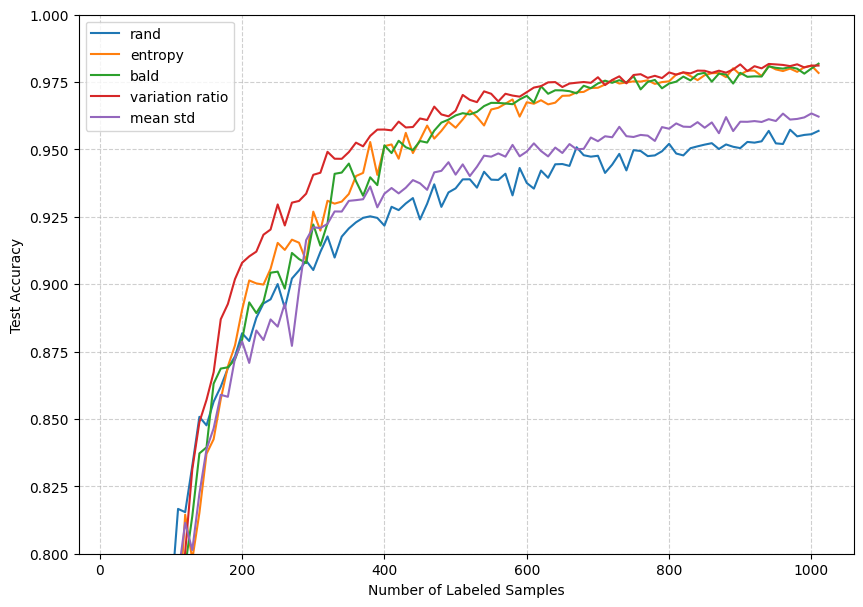

In [12]:
num_trials = 3

scenarios = [
    (maximise_random_acquisition, "rand"),
    (maximise_entropy_acquisition, "entropy"),
    (maximise_bald_acquisition, "bald"),
    (maximise_variation_ratio_acquisition, "variation ratio"),
    (maximise_mean_std_acquisition, "mean std")
]

for function, name in scenarios:
    for i in range(num_trials):
        run_active_learning(function, name=f"{name}{i}")


plt.figure(figsize=(10, 7))

for function, name in scenarios:
    accuracy_histories = []
    label_history = []

    for i in range(num_trials):
        df = pd.read_csv(f"{name}{i}.csv")
        label_history = df["label_history"].values
        accuracy_history = df["accuracy_history"].values
        accuracy_histories.append(accuracy_history)

    if len(accuracy_histories) > 0:
        accuracy_histories = np.array(accuracy_histories)
        accuracy_means = np.mean(accuracy_histories, axis=0)
        accuracy_stds = np.std(accuracy_histories, axis=0)

        line, = plt.plot(label_history, accuracy_means, label=f"{name}")
        # plt.fill_between(label_history, accuracy_means - accuracy_stds, accuracy_means + accuracy_stds, color=line.get_color(), alpha=0.2)

plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0.8, 1)
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()

In [13]:
# rand_label_history, rand_accuracy_history = run_active_learning(maximise_random_acquisition, name="rand")
# entropy_label_history, entropy_accuracy_history = run_active_learning(maximise_entropy_acquisition, name="entropy")
# bald_label_history, bald_accuracy_history = run_active_learning(maximise_bald_acquisition, name="bald")
# #variation_ratio_label_history, variation_ratio_accuracy_history = run_active_learning(maximise_variation_ratio_acquisition, name="variation ratio")
# mean_std_label_history, mean_std_accuracy_history = run_active_learning(maximise_mean_std_acquisition, name="mean std")

# plt.figure(figsize=(10, 7))
# plt.plot(rand_label_history, rand_accuracy_history, linestyle="-", label="rand")
# plt.plot(entropy_label_history, entropy_accuracy_history, linestyle="-", label="entropy")
# plt.plot(bald_label_history, bald_accuracy_history, linestyle="-", label="bald")
# #plt.plot(variation_ratio_label_history, variation_ratio_accuracy_history, linestyle="-", label="variation ratio")
# plt.plot(mean_std_label_history, mean_std_accuracy_history, linestyle="-", label="mean std")
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.ylim(0.8, 1)

# plt.legend()
# plt.show()


Recreation of figure 2
I'm reusing the non-deterministic data from above, for the deterministic data we set T = 1 and non_deterministic = False

Save found for rand0
Save found for rand1
Save found for rand2
Save found for entropy0
Save found for entropy1
Save found for entropy2
Save found for bald0
Save found for bald1
Save found for bald2
Save found for variation ratio0
Save found for variation ratio1
Save found for variation ratio2
Save found for mean std0
Save found for mean std1
Save found for mean std2
Save found for deterministic entropy0
Save found for deterministic entropy1
Save found for deterministic entropy2
Save found for deterministic bald0
Save found for deterministic bald1
Save found for deterministic bald2
Save found for deterministic variation ratio0
Save found for deterministic variation ratio1
Save found for deterministic variation ratio2


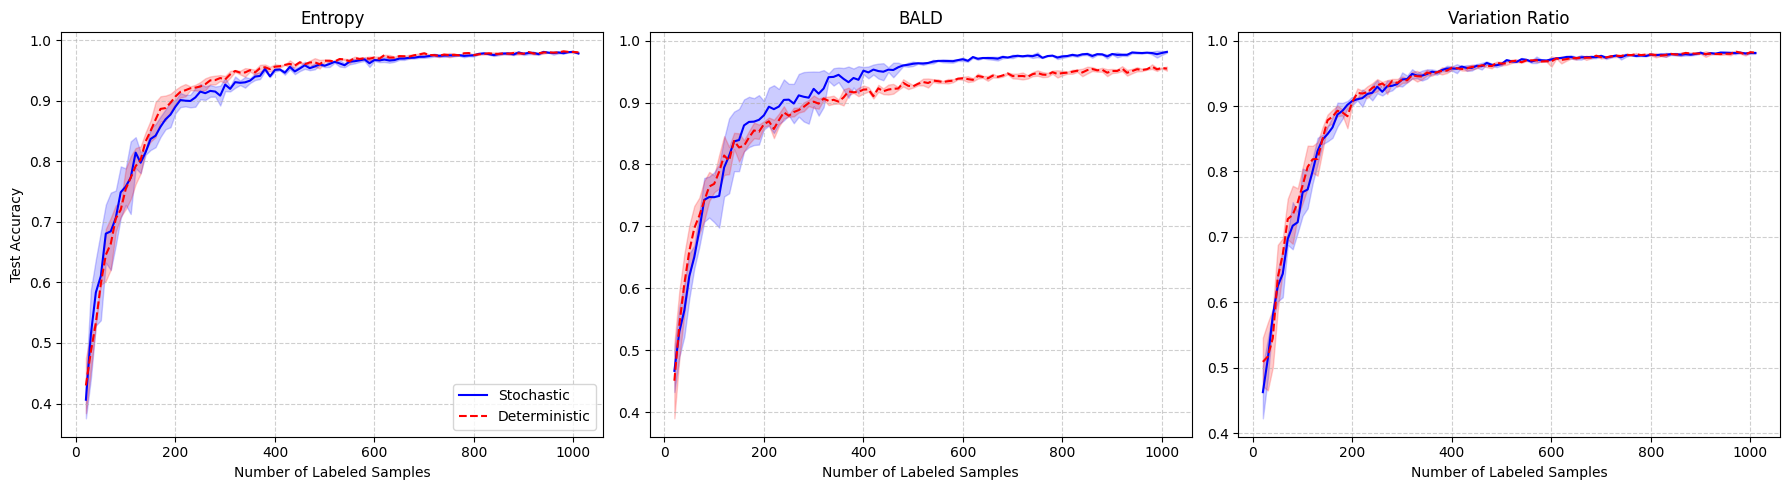

In [14]:
num_trials = 3

scenarios = [
    (maximise_random_acquisition, "rand", True),
    (maximise_entropy_acquisition, "entropy", True),
    (maximise_bald_acquisition, "bald", True),
    (maximise_variation_ratio_acquisition, "variation ratio", True),
    (maximise_mean_std_acquisition, "mean std", True),

    (maximise_entropy_acquisition, "deterministic entropy", False),
    (maximise_bald_acquisition, "deterministic bald", False),
    (maximise_variation_ratio_acquisition, "deterministic variation ratio", False)
]

for function, name, non_deterministic in scenarios:
    T = 100 if non_deterministic else 1

    for i in range(num_trials):
        run_active_learning(function, f"{name}{i}", T=T, non_deterministic=non_deterministic)

# The pairs to compare: (Stochastic Name, Deterministic Name, Title)
comparisons = [
    ("entropy", "deterministic entropy", "Entropy"),
    ("bald", "deterministic bald", "BALD"),
    ("variation ratio", "deterministic variation ratio", "Variation Ratio")
]

plt.figure(figsize=(18, 5))

for idx, (stoch_name, det_name, title) in enumerate(comparisons):
    ax = plt.subplot(1, 3, idx + 1)
    
    for name, color, label, style in [(stoch_name, "blue", "Stochastic", "-"), 
                                      (det_name, "red", "Deterministic", "--")]:
        
        accuracy_histories = []
        label_history = []

        for i in range(num_trials):
            try:
                df = pd.read_csv(f"{name}{i}.csv") 
                
                label_history = df["label_history"].values
                accuracy_histories.append(df["accuracy_history"].values)
            except FileNotFoundError:
                print(f"Warning: File {name}{i}.csv not found.")
                continue

        if len(accuracy_histories) > 0:
            accuracy_histories = np.array(accuracy_histories)
            mean_acc = np.mean(accuracy_histories, axis=0)
            std_acc = np.std(accuracy_histories, axis=0)

            ax.plot(label_history, mean_acc, label=label, color=color, linestyle=style)
            ax.fill_between(label_history, mean_acc - std_acc, mean_acc + std_acc, color=color, alpha=0.2)

    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xlabel("Number of Labeled Samples")
    
    if idx == 0:
        ax.set_ylabel("Test Accuracy")
        ax.legend()

plt.tight_layout()
plt.show()


In [15]:
# deterministic_entropy_label_history, deterministic_entropy_accuracy_history = run_active_learning(maximise_entropy_acquisition, name="deterministic entropy", T=1, non_deterministic=False)
# #deterministic_bald_label_history, deterministic_bald_accuracy_history = run_active_learning(maximise_bald_acquisition, name="deterministic bald", T=1, non_deterministic=False)
# #deterministic_variation_ratio_label_history, variation_ratio_accuracy_history = run_active_learning(maximise_variation_ratio_acquisition, name="deterministic variation ratio", T=1, non_deterministic=False)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# ax1.plot(entropy_label_history, entropy_accuracy_history, 'r-', label="entropy")
# ax1.plot(deterministic_entropy_label_history, deterministic_entropy_accuracy_history, 'b-', label="deterministic entropy")
# ax1.set_title("entropy")

# #ax2.plot(bald_label_history, bald_accuracy_history, 'r-', label="bald")
# #ax2.plot(deterministic_bald_label_history, deterministic_bald_accuracy_history, 'b-', label="deterministic bald")
# #ax2.set_title("BALD")

# # ax3.plot(variation_ratio_label_history, variation_ratio_accuracy_history, 'r-', label="Bayesian VAR")
# # ax3.plot(det_var_labels, det_var_accs, 'b-', label="Deterministic VAR")
# # ax3.set_title("Variation Ratio")

# # Formatting all plots at once
# for ax in [ax1, ax2, ax3]:
#     ax.plot(rand_label_history, rand_accuracy_history, 'k--', alpha=0.5, label="Random")
#     ax.set_xlabel("Labeled Samples")
#     ax.set_ylim(0.8, 1.0) 
#     ax.legend()
#     ax.grid(True, linestyle="--", alpha=0.6)

# ax1.set_ylabel("Test Accuracy")
# plt.tight_layout()
# plt.show()

Recreating figure 3

In [16]:
num_trials = 3

scenarios = [
    (maximise_random_acquisition, "rand"),
    (maximise_entropy_acquisition, "entropy"),
    (maximise_bald_acquisition, "bald"),
    (maximise_variation_ratio_acquisition, "variation ratio"),
    (maximise_mean_std_acquisition, "mean std")
]

for function, name in scenarios:
    for i in range(num_trials):
        run_active_learning(function, name=f"{name}{i}")

table_data = []

for function, name in scenarios:
    accuracy_histories = []
    label_history = []

    for i in range(num_trials):
        df = pd.read_csv(f"{name}{i}.csv")
        label_history = df["label_history"].values
        accuracy_history = df["accuracy_history"].values
        accuracy_histories.append(accuracy_history)

    thresholds = {}

    if len(accuracy_histories) > 0:
        accuracy_histories = np.array(accuracy_histories)
        accuracy_means = np.mean(accuracy_histories, axis=0)

        index_10 = np.where(accuracy_means >= 0.9)[0][0] * 10
        index_5 = np.where(accuracy_means >= 0.95)[0][0] * 10

        table_data.append({
            "name": name,
            "10%": index_10,
            "5%": index_5
        })

df = pd.DataFrame(table_data).set_index("name").T
print(df)


Save found for rand0
Save found for rand1
Save found for rand2
Save found for entropy0
Save found for entropy1
Save found for entropy2
Save found for bald0
Save found for bald1
Save found for bald2
Save found for variation ratio0
Save found for variation ratio1
Save found for variation ratio2
Save found for mean std0
Save found for mean std1
Save found for mean std2
name  rand  entropy  bald  variation ratio  mean std
10%    230      190   220              170       270
5%     650      360   380              340       560


Minimial extension:
Analytic Regression Baseline

New active learning loop for both regression models
Very similar to the previous active learning loop, except it doesn't accept any acquisition function and instead performs bayesian inference as requested.

In [17]:
"""   
Reload the data since it was modified earlier
"""
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [18]:
input_shape = (28, 28, 1)
num_classes = 10

"""   
Similar to previous model, but no longer uses dropout to mimic bayesian uncertainty,
also no longer softmaxes the output, and calculates MSE instead of accuracy
"""
def create_regression_model():
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation=None)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

create_regression_model().summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       495,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,994 (1.96 MB)

 Trainable params: 513,994 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def run_regression_active_learning(name="", mode="analytic"):
    if os.path.exists(name+".csv"):
        print("Save found for " + name)
        df = pd.read_csv(name+".csv")
        return df["label_history"].tolist(), df["rmse_history"].tolist()

    print("Save not found for " + name)

    """   
    Split the training dataset into: 
    100 validation indices 
    20 initially labelled indices
    60,000 - 100 - 20 unlabelled indices (pool)
    """
    all_indices = list(range(len(x_train)))
    random.shuffle(all_indices)

    validation_indices = all_indices[:100]
    labelled_indices = all_indices[100:120]
    pool_indices = all_indices[120:]

    label_history = []
    rmse_history = []

    """   
    Variables for bayesian inference
    """
    sigma2 = 1.0 
    s2 = 1.0

    for round_num in range(50):
        """   
        Create a new CNN, and fit it to the labelled data
        """
        early_stop = keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=3,
            restore_best_weights=True
        )

        model = create_regression_model()
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            x_train[labelled_indices],
            y_train[labelled_indices],
            epochs=20,
            batch_size=32,
            verbose=0, 
            callbacks=[early_stop]
        )

        # Model with all but the final layer frozen
        features = keras.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

        phi_train = features.predict(x_train[labelled_indices], verbose=0)
        phi_test = features.predict(x_test, verbose=0)
        phi_pool = features.predict(x_train[pool_indices], verbose=0)

        if mode == "analytic":
            # Analytic bayesian inference equation
            inverse_Sigma_prime = (1.0 / sigma2) * (phi_train.T @ phi_train) + (1.0 / s2) * np.eye(phi_train.shape[1])
            Sigma_prime = np.linalg.inv(inverse_Sigma_prime)
            mu_prime = Sigma_prime @ ((1.0 / sigma2) * (phi_train.T @ y_train[labelled_indices]))
            epistemic_uncertainties = np.sum((phi_pool @ Sigma_prime) * phi_pool, axis=1)
        elif mode == "mfvi":
            phi_sq_sum = np.sum(phi_train**2, axis=0) 
            s_vector = 1.0 / ((1.0 / sigma2) * phi_sq_sum + (1.0 / s2))
            mu_prime = (s_vector[:, np.newaxis]) * ((1.0 / sigma2) * (phi_train.T @ y_train[labelled_indices]))
            epistemic_uncertainties = np.sum((phi_pool**2) * s_vector, axis=1)

        # Calculate predictions and RMSE
        test_predictions = phi_test @ mu_prime
        rmse = np.sqrt(np.mean((test_predictions - y_test) ** 2))

        print("Round " + str(round_num) + " rmse: " + str(rmse)) 

        label_history.append(len(labelled_indices))
        rmse_history.append(rmse)

        """   
        Occasionally save checkpoints in case computation crashes
        """

        if round_num % 10 == 0: 
            dataframe = pd.DataFrame({
                "label_history": label_history, 
                "rmse_history": rmse_history
            })
            dataframe.to_csv(name+"_checkpoint.csv", index=False)

        """   
        Acquisition by maximising epistemic uncertainty
        """
        
        # phi_pool @ Sigma_prime @ phi_pool was causing issues
        topk = np.argsort(epistemic_uncertainties)[-10:]
        acquired_indices = [pool_indices[i] for i in topk]

        for acquired_index in acquired_indices: 
            labelled_indices.append(acquired_index)
            pool_indices.remove(acquired_index)

        del model 
        keras.backend.clear_session()

    dataframe = pd.DataFrame({
        "label_history": label_history , 
        "rmse_history": rmse_history
    })
    dataframe.to_csv(name+".csv", index=False)

    if os.path.exists(f"{name}_checkpoint.csv"):
        os.remove(f"{name}_checkpoint.csv")

    return label_history, rmse_history


Save found for analytic0
Save found for analytic1
Save found for analytic2
Save found for mfvi0
Save found for mfvi1
Save found for mfvi2


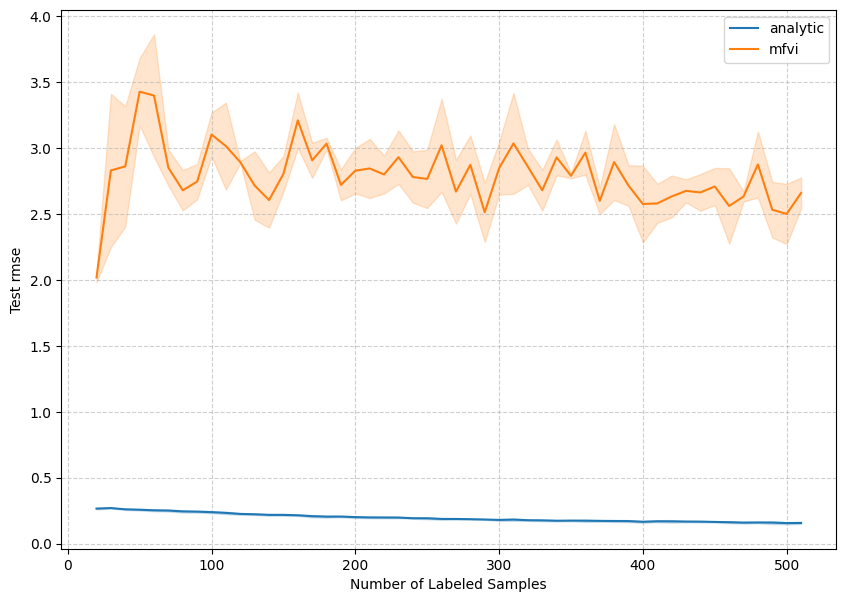

In [20]:
num_trials = 3

scenarios = ["analytic", "mfvi"]

for name in scenarios:
    for i in range(num_trials):
        run_regression_active_learning(f"{name}{i}", name)


plt.figure(figsize=(10, 7))

for name in scenarios:
    rmse_histories = []
    label_history = []

    for i in range(num_trials):
        df = pd.read_csv(f"{name}{i}.csv")
        label_history = df["label_history"].values
        rmse_history = df["rmse_history"].values
        rmse_histories.append(rmse_history)

    if len(rmse_histories) > 0:
        rmse_histories = np.array(rmse_histories)
        rmse_means = np.mean(rmse_histories, axis=0)
        rmse_stds = np.std(rmse_histories, axis=0)

        line, = plt.plot(label_history, rmse_means, label=f"{name}")
        plt.fill_between(label_history, rmse_means - rmse_stds, rmse_means + rmse_stds, color=line.get_color(), alpha=0.2)

plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test rmse")
plt.legend()
plt.show()

Novel contribution
Diversity-aware acquisition

In [21]:
keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [22]:
def diversity_aware_mean_std_acquisition(model, pool_indices, x_train, k, T=100, sample_size=1000, non_deterministic=True, lam=0):
    """ 
    Fetch the k indices for the points that maximise the mean STD
    STD sigma_c = sqrt[ E[p(y=c | x, w)^2] - E[p(y=c | x, w)]^2 ]
    sigma = avg(sigma_c) for c = 0, ..., 9
    """
    random_indices = random.sample(pool_indices, sample_size)
    x_pool = x_train[random_indices]

    # Sample model
    model_outputs = [] 
    for _ in range(T):
        model_output = model(x_pool, training=non_deterministic)
        model_outputs.append(model_output)

    model_output = np.array(model_output)

    # Calculate E[p^2]
    expectation_of_square = np.mean(np.square(model_output), axis=0)

    # Calculate E[p]^2
    square_of_expectation = np.square(np.mean(model_output, axis=0))

    sigma_scores = np.sqrt(expectation_of_square - square_of_expectation)
    diverse_aware_scores = sigma_scores.copy()

    local_acquired_indices = []
    batch_size = k // 5

    for iter in range(5):
        """
        Fetch the k/5 points that maximise the acquisition function,
        then subtract the max similarity from the remaining points to 
        represent the diversity aware scores
        """
        bestk = np.argsort(diverse_aware_scores)[-k:]
        local_acquired_indices.extend(bestk)

        if iter < 4:
            diverse_aware_scores[local_acquired_indices] = -np.inf
            selected_outputs = expectation_of_square[local_acquired_indices]
            mean_predictions = np.mean(model_output, axis=0)
            similarity_scores = rbf_kernel(selected_outputs, mean_predictions)

            diverse_aware_scores = diverse_aware_scores - (lam * np.max(similarity_scores))
            diverse_aware_scores[local_acquired_indices] = -np.inf

    return [random_indices[i] for i in local_acquired_indices]

    


In [ ]:
num_trials = 1
k = 50

for i in range(num_trials):
    run_active_learning(maximise_mean_std_acquisition,
                        name=f"mean std{i}", k=k)
    
for lam in [0.1, 10]:
    for i in range(num_trials):
        run_active_learning(maximise_mean_std_acquisition,
                            name=f"mean std diverse{i}, {lam}", k=k, lam=lam, num_rounds=20)

plt.figure(figsize=(10, 7))

plotting_scenarios = [("mean std", "Baseline (Mean Std)")]
for lam in [0.1, 10]:
    plotting_scenarios.append((f"mean std diverse{{i}}, {lam}", f"Diverse (λ={lam})"))

for name_pattern, label_name in plotting_scenarios:
    accuracy_histories = []
    label_history = []

    for i in range(num_trials):
        if "{i}" in name_pattern:
            filename = name_pattern.format(i=i)
        else:
            filename = f"{name_pattern}{i}"
            
        try:
            df = pd.read_csv(f"{filename}.csv")
            label_history = df["label_history"].values
            accuracy_history = df["accuracy_history"].values
            accuracy_histories.append(accuracy_history)
        except FileNotFoundError:
            continue

    if len(accuracy_histories) > 0:
        accuracy_histories = np.array(accuracy_histories)
        accuracy_means = np.mean(accuracy_histories, axis=0)
        accuracy_stds = np.std(accuracy_histories, axis=0)

        line, = plt.plot(label_history, accuracy_means, label=label_name)
        
        if num_trials > 1:
            plt.fill_between(label_history, 
                             accuracy_means - accuracy_stds, 
                             accuracy_means + accuracy_stds, 
                             color=line.get_color(), alpha=0.2)

plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0.8, 1)
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()




Save found for mean std0
Save found for mean std diverse0, 0.1
Save found for mean std diverse0, 10
Save not found for mean std diverse0, 100
Round 0 accuracy: 0.4081000089645386

Round 1 accuracy: 0.4426000118255615


KeyboardInterrupt: 